# Train a binary XNORNet for deploying in FPGA
This tutorial will help you go through the procedures of training a one-layer XNorNet as a perceptron on mnist dataset, and how to deploy trained weights and images into magma.
This tutorial has borrowed some codes from https://github.com/BenBBear/MNIST-XNORNet.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_func import *
from mnist import read_data_sets
mnist = read_data_sets('MNIST_data')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Training
Here we train a xnor network following description(https://arxiv.org/abs/1603.05279). Considering the limit amount of resources on ice40, we resize the image from 28x28 to 16x16. We use only one fully-connected layer to conduct classification. Feel free to add conv layers if you have a larger resource.

In [2]:
# Build Computational Graph
sess = tf.InteractiveSession()

# Initialize placeholders for data & labels
x = tf.placeholder(tf.float32, shape=[None, 256])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

# reshape to make image volumes
x_image = tf.reshape(x, [-1,1,1,256])
x_image_drop = tf.nn.dropout(x_image, keep_prob)

W_fc = weight_variable([1, 1, 256, 10])
BW_fc = binarize_weights(W_fc)

y_conv = tf.reshape(conv2d(x_image, BW_fc), [-1, 10])

# create train ops
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# initialize all variables
sess.run(tf.global_variables_initializer())

# train loop
for i in range(10000):
    batch = mnist.train.next_batch(50)
    if i % 1000 == 0:
        print("test accuracy %g"%accuracy.eval(feed_dict={
            x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d,r training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    

Tensor("Variable/read:0", shape=(1, 1, 256, 10), dtype=float32)
test accuracy 0.1119
step 0,r training accuracy 0.16
step 100,r training accuracy 0.24
step 200,r training accuracy 0.24
step 300,r training accuracy 0.18
step 400,r training accuracy 0.24
step 500,r training accuracy 0.42
step 600,r training accuracy 0.4
step 700,r training accuracy 0.5
step 800,r training accuracy 0.44
step 900,r training accuracy 0.54
test accuracy 0.5274
step 1000,r training accuracy 0.52
step 1100,r training accuracy 0.46
step 1200,r training accuracy 0.56
step 1300,r training accuracy 0.56
step 1400,r training accuracy 0.58
step 1500,r training accuracy 0.6
step 1600,r training accuracy 0.54
step 1700,r training accuracy 0.56
step 1800,r training accuracy 0.58
step 1900,r training accuracy 0.66
test accuracy 0.6486
step 2000,r training accuracy 0.58
step 2100,r training accuracy 0.72
step 2200,r training accuracy 0.64
step 2300,r training accuracy 0.62
step 2400,r training accuracy 0.66
step 2500,r t

# Save Weights
Here we save the weights, and prepare 10 mnist samples, whose labels ranging from 0 to 9 to a pickle file, which could be used later to initiate ROM in FPGA.

In [80]:
import pickle
# trained binary weights
res = BW_fc.eval()
alpha = np.abs(res).sum(0).sum(0).sum(0) / res[:,:,:,0].size
BW = np.sign(res)
BW = np.squeeze(BW, axis=(0, 1))
BW = BW.T
BW[BW==-1] = 0

# mnist samples ranging from label 0 to 9
imgs = [mnist.test.images[3], mnist.test.images[2], mnist.test.images[208], mnist.test.images[811], mnist.test.images[1140], 
       mnist.test.images[102], mnist.test.images[814], mnist.test.images[223],mnist.test.images[128], mnist.test.images[214]]
imgs = np.vstack(imgs)
imgs[imgs==-1]=0

weights_int16 = np.zeros((10, 16), dtype=np.uint16)
for index in range(10):
    for i in range(16):
        for j in range(15):
            weights_int16[index, i] += BW[index, 16 * i + j]
            weights_int16[index, i] = np.left_shift(weights_int16[index, i], 1)
        weights_int16[index, i] += BW[index, 16 * i + 15]

imgs_int16 = np.zeros((10, 16), dtype=np.uint16)
for index in range(10):
    for i in range(16):
        for j in range(15):
            imgs_int16[index, 15-i] += imgs[index, 16 * (15 - j) + i]
            imgs_int16[index, 15-i] = np.left_shift(imgs_int16[index, 15-i], 1)
        imgs_int16[index, 15-i] += imgs[index, 16 * 0 + i]
        
pickle.dump({'imgs':imgs, 'weights': BW, 'alpha':alpha, 
             'imgs_int16':imgs_int16, 'weights_int16':weights_int16}, open( "BNN.pkl", "wb" ))


## Simulate on CPU
The following code simulates the computation on FPGA on CPU.

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
def dis_img(imgs, index):
    img = imgs[index, :]
    img = np.reshape(img, [16, 16])
    plt.imshow(img, cmap='gray')
    plt.show()

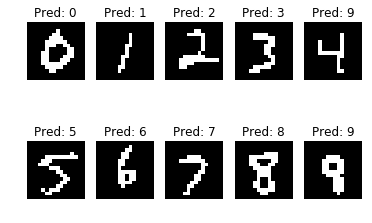

In [81]:
for img_index in range(10):
    res = []
    for i in range(10):
        kk = np.logical_not(np.logical_xor(imgs[img_index, :], BW[i, :].T))
        pop_count = np.sum(kk)
        res.append(pop_count)
    plt.subplot(2, 5, img_index + 1)
    img = np.reshape(imgs[img_index, :], [16, 16])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pred: " + str(np.argmax(res, axis=0)))
plt.show()